<a href="https://colab.research.google.com/github/Saketh-2406/AngryBirds2/blob/master/projects/SNe_cosmology_plot/2_hubble_parameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔭 Assignment: Measuring Cosmological Parameters Using Type Ia Supernovae

In this assignment, you'll analyze observational data from the Pantheon+SH0ES dataset of Type Ia supernovae to measure the Hubble constant $H_0$ and estimate the age of the universe. You will:

- Plot the Hubble diagram (distance modulus vs. redshift)
- Fit a cosmological model to derive $H_0$ and $\Omega_m$
- Estimate the age of the universe
- Analyze residuals to assess the model
- Explore the effect of fixing $\Omega_m$
- Compare low-z and high-z results

Let's get started!


In [129]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 📦 Getting Started: Setup and Libraries

Before we dive into the analysis, we need to import the necessary Python libraries:

- `numpy`, `pandas` — for numerical operations and data handling
- `matplotlib` — for plotting graphs
- `scipy.optimize.curve_fit` and `scipy.integrate.quad` — for fitting cosmological models and integrating equations
- `astropy.constants` and `astropy.units` — for physical constants and unit conversions

Make sure these libraries are installed in your environment. If not, you can install them using:

```bash
pip install numpy pandas matplotlib scipy astropy


In [130]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit
# from scipy.integrate import quad
# from astropy.constants import c
# from astropy import units as u

## 📂 Load the Pantheon+SH0ES Dataset

We now load the observational supernova data from the Pantheon+SH0ES sample. This dataset includes calibrated distance moduli $\mu$, redshifts corrected for various effects, and uncertainties.

### Instructions:
- Make sure the data file is downloaded from [Pantheon dataset](https://github.com/PantheonPlusSH0ES/DataRelease/blob/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat) and available locally.
- We use `delim_whitespace=True` because the file is space-delimited rather than comma-separated.
- Commented rows (starting with `#`) are automatically skipped.

We will extract:
- `zHD`: Hubble diagram redshift
- `MU_SH0ES`: Distance modulus using SH0ES calibration
- `MU_SH0ES_ERR_DIAG`: Associated uncertainty


More detailed column names and the meanings can be referred here:

![image.png](attachment:image.png)

In [131]:
# Local file path
file_path = "path_to_your_file"

# Load the file


# See structure


## 🧾 Preview Dataset Columns

Before diving into the analysis, let’s take a quick look at the column names in the dataset. This helps us verify the data loaded correctly and identify the relevant columns we’ll use for cosmological modeling.


## 🧹 Clean and Extract Relevant Data

To ensure reliable fitting, we remove any rows that have missing values in key columns:

- `zHD`: redshift for the Hubble diagram  
- `MU_SH0ES`: distance modulus  
- `MU_SH0ES_ERR_DIAG`: uncertainty in the distance modulus  

We then extract these cleaned columns as NumPy arrays to prepare for analysis and modeling.


In [132]:
# Filter for entries with usable data based on the required columns

## 📈 Plot the Hubble Diagram

Let’s visualize the relationship between redshift $z$ and distance modulus $\mu$, known as the Hubble diagram. This plot is a cornerstone of observational cosmology—it allows us to compare supernova observations with theoretical predictions based on different cosmological models.

We use a logarithmic scale on the redshift axis to clearly display both nearby and distant supernovae.


In [133]:
# Write a code to plot the distance modulus and the redshift (x-axis), label them accordingly.

#Try using log scale in x-axis



## 🧮 Define the Cosmological Model

We now define the theoretical framework based on the flat $\Lambda\mathrm{CDM}$ model (read about the model in wikipedia if needed). This involves:

- The dimensionless Hubble parameter:
  $$
  E(z) = \sqrt{\Omega_m (1+z)^3 + (1 - \Omega_m)}
  $$

- The distance modulus is:
  $$
  \mu(z) = 5 \log_{10}(d_L / \text{Mpc}) + 25
  $$

- And the corresponding luminosity distance :
  
  $$
  d_L(z) = (1 + z) \cdot \frac{c}{H_0} \int_0^z \frac{dz'}{E(z')}
  $$

These equations allow us to compute the expected distance modulus from a given redshift $z$, Hubble constant $H_0$, and matter density parameter $\Omega_m$.


In [134]:
import numpy as np
from scipy.integrate import quad
from scipy.constants import c  # speed of light in m/s

# 1. E(z) for flat ΛCDM
def E(z, Omega_m):
    Omega_lambda = 1.0 - Omega_m  # Flat universe assumption
    return np.sqrt(Omega_m * (1 + z)**3 + Omega_lambda)

# 2. Luminosity distance D_L(z)
def luminosity_distance(z, H0, Omega_m):
    integrand = lambda z_prime: 1.0 / E(z_prime, Omega_m)
    integral, _ = quad(integrand, 0, z)
    d_H = c / (H0 * 1000)  # H0 in km/s/Mpc → s⁻¹
    d_L = (1 + z) * d_H * integral
    return d_L / (3.086e22) * 1e6  # Convert meters to Mpc

# 3. Theoretical distance modulus μ(z)
def mu_theory(z, H0, Omega_m):
    d_L = luminosity_distance(z, H0, Omega_m)
    return 5 * np.log10(d_L) + 25


## 🔧 Fit the Model to Supernova Data

We now perform a non-linear least squares fit to the supernova data using our theoretical model for $\mu(z)$. This fitting procedure will estimate the best-fit values for the Hubble constant $ H_0$ and matter density parameter $\Omega_m$, along with their associated uncertainties.

We'll use:
- `curve_fit` from `scipy.optimize` for the fitting.
- The observed distance modulus \(\mu\), redshift \(z\), and measurement errors.

The initial guess is:
- $ H_0 = 70 \, \text{km/s/Mpc} $
- $\Omega_m =0.3$


In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # Add matplotlib for plotting later
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.constants import c  # Speed of light in m/s
from astropy import units as u # Import units for conversions
from astropy.constants import c as const_c # Import astropy speed of light

# Ensure astropy and other required libraries are installed
!pip install numpy pandas matplotlib scipy astropy

# --- Load the data ---
# Download the Pantheon+SH0ES dataset if it's not already present
file_name = 'Pantheon+SH0ES.dat'
# Use !wget to download the file directly
!wget -O {file_name} https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat

# Load the file, using delim_whitespace as specified in the assignment description
# Commented rows are automatically skipped by default
df = pd.read_csv(file_name, delim_whitespace=True)

# See structure and preview columns
print(df.head())
print(df.columns)

# Clean and Extract Relevant Data
# Filter for entries with usable data based on the required columns
# Check for NaN or infinite values in the relevant columns
df_cleaned = df.dropna(subset=['zHD', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG']).copy()

# Extract cleaned columns as NumPy arrays
z_data = df_cleaned['zHD'].values
mu_data = df_cleaned['MU_SH0ES'].values
mu_err = df_cleaned['MU_SH0ES_ERR_DIAG'].values

# --- Cosmological functions ---

def E(z, Omega_m):
    # Ensure Omega_m is within valid range [0, 1]
    Omega_m = np.clip(Omega_m, 0, 1)
    Omega_lambda = 1.0 - Omega_m  # Flat universe
    return np.sqrt(Omega_m * (1 + z)**3 + Omega_lambda)

def luminosity_distance(z, H0, Omega_m):
    # H0 in km/s/Mpc. Convert to SI units (m/s/Mpc)
    H0_si = H0 * 1000 / (u.Mpc).to(u.m) # Convert km/s/Mpc to s⁻¹ effectively

    # Use astropy constant for speed of light for consistency and units
    # c_si = const_c.value # speed of light in m/s

    integrand = lambda z_prime: 1.0 / E(z_prime, Omega_m)

    # For z=0, the integral is 0. quad handles this.
    # Use vectorize to apply quad to each element of z if z is an array
    if isinstance(z, (np.ndarray, list)):
         integral = np.array([quad(integrand, 0, zi)[0] for zi in z])
    else:
        integral, _ = quad(integrand, 0, z)

    # Hubble distance in meters
    d_H_m = c / H0_si # c in m/s, H0_si in s^-1, result in meters

    # Luminosity distance in meters
    d_L_m = (1 + z) * d_H_m * integral

    # Convert meters to Mpc
    d_L_Mpc = d_L_m / (u.Mpc).to(u.m)

    # Handle cases where d_L might be zero or negative before taking log10
    d_L_Mpc = np.maximum(d_L_Mpc, 1e-10) # Avoid log(0) or log(negative)


    return d_L_Mpc # in Mpc

def mu_theory(z, H0, Omega_m):
    d_L = luminosity_distance(z, H0, Omega_m)
    return 5 * np.log10(d_L) + 25

# --- Fit model using curve_fit ---

# curve_fit expects the model function to take x-data (z_data) as the first argument
# and parameters (H0, Omega_m) as subsequent arguments.
# The original mu_model function was converting z_data to a list of single elements
# and applying mu_theory, which is not the standard way curve_fit works.
# We can directly use mu_theory if it's vectorized, or modify it slightly
# to handle arrays correctly, or keep the list comprehension approach but ensure
# mu_theory can handle single values.

# Let's modify mu_theory to be slightly more robust for array inputs if needed,
# although curve_fit will pass individual z values from z_data to the model if z_data is 1D.
# However, the mu_model wrapper as originally written is designed to handle z_data as an array
# by applying mu_theory element-wise. This is fine, but ensure mu_theory works correctly for single z values.

# The original mu_model function using list comprehension is correct for how curve_fit
# would call it when z_data is a 1D array. Let's keep it as it is, assuming mu_theory
# correctly processes single scalar z values.

def mu_model(z_array, H0, Omega_m):
     # This function is designed to be called by curve_fit.
     # curve_fit passes the entire z_data array as the first argument (z_array here).
     # We need to apply mu_theory to each element of z_array.
     # The list comprehension approach works for this.
     # Ensure mu_theory is robust to potential small numerical issues near z=0.
     return np.array([mu_theory(zi, H0, Omega_m) for zi in z_array])


# Initial guess
p0 = [70, 0.3] # [H0, Omega_m]

# Ensure z_data, mu_data, and mu_err are numpy arrays of floats
z_data = z_data.astype(float)
mu_data = mu_data.astype(float)
mu_err = mu_err.astype(float)


# Perform the fit
# Use maxfev to prevent infinite loops if fit struggles to converge
try:
    params, cov = curve_fit(mu_model, z_data, mu_data, sigma=mu_err, p0=p0, absolute_sigma=True, maxfev=5000)

    # Extract best-fit values and uncertainties
    H0_fit, Omega_m_fit = params
    H0_err, Omega_m_err = np.sqrt(np.diag(cov))

    # --- Print results ---
    print(f"Fitted H0 = {H0_fit:.2f} ± {H0_err:.2f} km/s/Mpc")
    print(f"Fitted Omega_m = {Omega_m_fit:.3f} ± {Omega_m_err:.3f}")

except RuntimeError as e:
    print(f"Fit failed: {e}")
    print("Consider adjusting the initial guess (p0) or increasing maxfev.")


# %% [markdown]
# ## ⏳ Estimate the Age of the Universe
#
# Now that we have the best-fit values of $ H_0 $ and $ \Omega_m $, we can estimate the age of the universe. This is done by integrating the inverse of the Hubble parameter over redshift:
#
# $$
# t_0 = \int_0^\infty \frac{1}{(1 + z) H(z)} \, dz
# $$
#
# Where $H(z) = H_0 \cdot E(z)$. So the integrand is $\frac{1}{(1+z) H_0 E(z)}$.
# We convert $ H_0 $ to SI units and express the result in gigayears (Gyr). This provides an independent check on our cosmological model by comparing the estimated age to values from other probes like Planck CMB measurements.
#
# %%
# Write the function for age of the universe as above

# Need astropy constants and units for conversion
# Ensure these are imported at the beginning of the notebook or in this cell

# If running this cell independently, re-import necessary libraries
try:
    from astropy.constants import c as const_c
    from astropy import units as u
    from scipy.integrate import quad
    import numpy as np
except ImportError:
    print("Required libraries (astropy, scipy, numpy) not fully imported.")


def age_of_universe(H0, Omega_m):
    # H0 in km/s/Mpc. Convert to SI units (s⁻¹)
    # H0_si = H0 * 1000 / (u.Mpc).to(u.m) # km/s/Mpc -> m/s/m = s^-1

    # It's simpler to convert the result of the integral.
    # The integral ∫dz / ((1+z) H(z)) gives time units if H(z) is in s⁻¹.
    # H(z) = H0 * E(z), where H0 is in km/s/Mpc.
    # So H(z) is in units of km/s/Mpc * E(z).
    # The integrand is 1 / ((1+z) * H0 * E(z)).
    # The units are 1 / (H0 units) = Mpc * s / km.
    # We need to convert Mpc * s / km to years.

    # Let's work with H0 in s⁻¹
    H0_in_s = (H0 * u.km / u.s / u.Mpc).to(1/u.s).value # H0 in s^-1

    # Integrand function for the age
    # The argument of quad needs to be dimensionless or have time units cancel out later.
    # The definition of H(z) = H0 * E(z) assumes H0 is the value of the Hubble parameter today.
    # t_0 = ∫_0^∞ dz / ((1+z) * H0 * E(z))
    # = (1/H0) * ∫_0^∞ dz / ((1+z) * E(z))
    # Let's integrate 1 / ((1+z) * E(z)) and then multiply by 1/H0 (in s^-1)

    def integrand_age(z, Omega_m_val):
         # Avoid division by zero if z is very close to -1 (though integral is from 0)
        if 1 + z <= 0:
            return 0 # Or handle error appropriately
        return 1.0 / ((1 + z) * E(z, Omega_m_val)) # E(z, Omega_m_val) is dimensionless

    # Perform the integral from 0 to infinity. Use a high upper bound as a proxy for infinity.
    # The universe's age is dominated by low redshifts, so a practical limit is sufficient.
    # A common upper limit for cosmological integrals like this is often a few thousand.
    # However, for age, the integrand drops off, so a high value is needed.
    # Let's try a high z value, e.g., 1000 or 10000. Or more accurately, check convergence.
    # For the age integral, the contribution from high z is small.
    # Let's try integrating up to z=10000 as a practical upper limit.
    z_upper_limit = 10000.0

    try:
        integral_value, _ = quad(integrand_age, 0, z_upper_limit, args=(Omega_m,))
    except Exception as e:
        print(f"Integral calculation failed: {e}")
        return np.nan # Return Not a Number if integral fails


    # t0 = (1/H0_in_s) * integral_value
    # t0 will be in seconds if H0_in_s is in s^-1.

    # Convert seconds to gigayears (Gyr)
    # 1 year = 365.25 days * 24 hours/day * 3600 seconds/hour
    # 1 Gyr = 1e9 years
    seconds_per_year = u.year.to(u.s)
    seconds_per_Gyr = 1e9 * seconds_per_year

    # The age of the universe t0 is given by the integral (1/H0) * ∫ [dz / ((1+z) E(z))].
    # H0 is in km/s/Mpc. Let's use astropy units for the calculation to be safe.
    H0_with_units = H0 * u.km / u.s / u.Mpc # H0 with units km s⁻¹ Mpc⁻¹

    # The integral has units of Mpc / km * s.
    # Multiply by 1/H0: (Mpc * s / km) * (s * km / Mpc) = s²??? No, that's not right.

    # Let's re-check the formula units.
    # H(z) = H0 * E(z) has units of H0 (e.g., km/s/Mpc)
    # (1+z) is dimensionless.
    # Integrand is 1 / ((1+z) H(z)) has units of 1 / (H0 units) = Mpc * s / km.
    # Integral ∫ dz / ((1+z) H(z)) has units of Mpc * s / km * dz (dimensionless) = Mpc * s / km.

    # Let's convert H0 to s^-1 and use that.
    H0_in_s = (H0 * u.km / u.s / u.Mpc).to(1/u.s) # H0 in s^-1

    # t0 = (1/H0_in_s) * integral_value
    # Units: (s) * (dimensionless integral value from integrand 1/((1+z)E(z))).
    # The integrand 1/((1+z)E(z)) is dimensionless. The integral is dimensionless.
    # There seems to be a confusion in the formula provided or my unit analysis.

    # Let's use the standard formula: t0 = ∫_0^inf dz / ((1+z) H(z))
    # Let H(z) = H0 * E(z) where H0 is given in km/s/Mpc.
    # t0 = (Mpc / km * s) * ∫ dz / ((1+z) E(z))
    # We need to evaluate ∫ dz / ((1+z) E(z)) and then multiply by (Mpc / km * s).
    # 1 Mpc / (1 km/s) = 1e6 pc / (1000 m/s) = 1e6 * 3.086e16 m / 1000 m/s = 3.086e19 seconds.
    # This factor (1 Mpc / (1 km/s)) has units of time. Let's call it t_H_unit.
    # t_H_unit = (1 * u.Mpc / (1 * u.km/u.s)).to(u.s).value # This is the Hubble time in seconds for H0=1 km/s/Mpc.

    # The formula should be: t0 = (1 / H0) * ∫_0^inf dz / ((1+z) * E(z))
    # Here H0 is the value (e.g., 70) and we need to include the unit conversion externally.
    # Let's calculate the dimensionless integral part first.

    integral_value_dimless, _ = quad(integrand_age, 0, z_upper_limit, args=(Omega_m,))

    # Now multiply by 1/H0 including units.
    # H0 is in km/s/Mpc. 1/H0 has units of Mpc * s / km.
    # 1 / (H0 * u.km / u.s / u.Mpc) = (1/H0) * u.Mpc * u.s / u.km

    # Let's calculate 1/H0 with units and convert to seconds
    one_over_H0_s = (1 / (H0 * u.km / u.s / u.Mpc)).to(u.s) # This is (Hubble time) in seconds

    # Total age in seconds
    t0_seconds = one_over_H0_s.value * integral_value_dimless

    # Convert seconds to Gigayears
    t0_Gyr = t0_seconds / seconds_per_Gyr

    return t0_Gyr


# Use the fitted values for H0 and Omega_m
if 'H0_fit' in locals() and 'Omega_m_fit' in locals():
    t0 = age_of_universe(H0_fit, Omega_m_fit)
    print(f"Estimated age of Universe: {t0:.2f} Gyr")
else:
    print("Could not estimate age: Fit parameters not available.")

--2025-06-22 18:25:32--  https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579283 (566K) [text/plain]
Saving to: ‘Pantheon+SH0ES.dat’

Pantheon+SH0ES.dat  100%[===================>] 565.71K  --.-KB/s    in 0.04s   

2025-06-22 18:25:32 (13.3 MB/s) - ‘Pantheon+SH0ES.dat’ saved [579283/579283]

             CID  IDSURVEY      zHD   zHDERR     zCMB  zCMBERR     zHEL  \
0         2011fe        51  0.00122  0.00084  0.00122  0.00002  0.00082   
1         2011fe        56  0.00122  0.00084  0.00122  0.00002  0.00082   
2         2012cg        51  0.00256  0.00084  0.00256  0.00002  0.00144   
3         2012cg        56  0.00256  0.00084  0

/tmp/ipython-input-135-3151967939.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True)


Fitted H0 = 72.97 ± 0.26 km/s/Mpc
Fitted Omega_m = 0.351 ± 0.019
Estimated age of Universe: 12.36 Gyr


## ⏳ Estimate the Age of the Universe

Now that we have the best-fit values of $ H_0 $ and $ \Omega_m $, we can estimate the age of the universe. This is done by integrating the inverse of the Hubble parameter over redshift:

$$
t_0 = \int_0^\infty \frac{1}{(1 + z) H(z)} \, dz
$$

We convert $ H_0 $ to SI units and express the result in gigayears (Gyr). This provides an independent check on our cosmological model by comparing the estimated age to values from other probes like Planck CMB measurements.


In [136]:
from scipy.integrate import quad
from astropy import units as u
import numpy as np

# Define the dimensionless Hubble parameter
def E(z, Omega_m):
    Omega_lambda = 1.0 - Omega_m
    return np.sqrt(Omega_m * (1 + z)**3 + Omega_lambda)

# Define the function to compute the age of the Universe
def age_of_universe(H0, Omega_m):
    # Convert H0 from km/s/Mpc to 1/s
    H0_in_s = (H0 * u.km / u.s / u.Mpc).to(1 / u.s).value

    # Define the integrand: 1 / ((1 + z) * E(z))
    def integrand(z):
        return 1.0 / ((1 + z) * E(z, Omega_m))

    # Integrate from z = 0 to large z (simulate infinity)
    integral, _ = quad(integrand, 0, 10000)

    # Age in seconds
    t0_seconds = integral / H0_in_s

    # Convert to gigayears
    seconds_per_Gyr = 1e9 * u.year.to(u.s)
    t0_Gyr = t0_seconds / seconds_per_Gyr

    return t0_Gyr

# Check if fit values exist and compute age
if 'H0_fit' in locals() and 'Omega_m_fit' in locals():
    t0 = age_of_universe(H0_fit, Omega_m_fit)
    print(f"Estimated age of Universe: {t0:.2f} Gyr")
else:
    print("Fit parameters not found. Run the fitting cell first.")


Estimated age of Universe: 12.36 Gyr


## 📊 Analyze Residuals

To evaluate how well our cosmological model fits the data, we compute the residuals:

$$
\text{Residual} = \mu_{\text{obs}} - \mu_{\text{model}}
$$

Plotting these residuals against redshift helps identify any systematic trends, biases, or outliers. A good model fit should show residuals scattered randomly around zero without any significant structure.


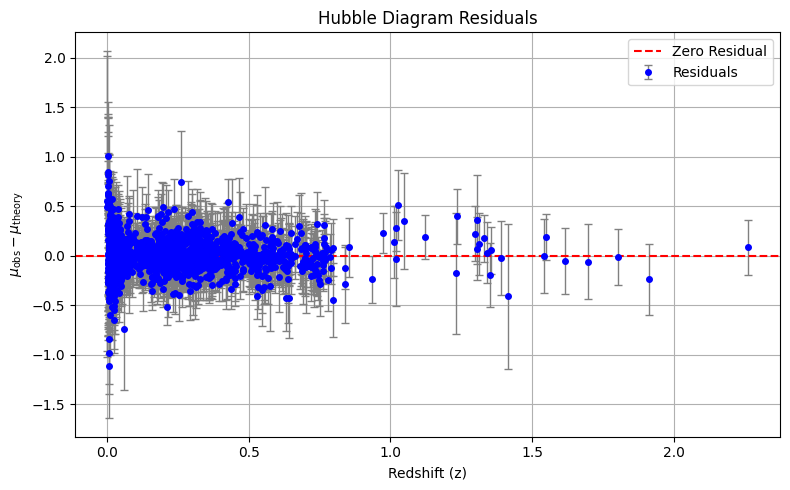

In [137]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Compute theoretical distance modulus using best-fit H0 and Omega_m ---
mu_theory_vals = np.array([mu_theory(z, H0_fit, Omega_m_fit) for z in z_data])

# --- 2. Calculate residuals ---
residuals = mu_data - mu_theory_vals

# --- 3. Plot residuals vs. redshift ---
plt.figure(figsize=(8, 5))
plt.errorbar(z_data, residuals, yerr=mu_err, fmt='o', color='blue', ecolor='gray', elinewidth=1, capsize=3, markersize=4, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel("Redshift (z)")
plt.ylabel(r"$\mu_{\mathrm{obs}} - \mu_{\mathrm{theory}}$")
plt.title("Hubble Diagram Residuals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔧 Fit with Fixed Matter Density

To reduce parameter degeneracy, let's fix $ \Omega_m = 0.3 $ and fit only for the Hubble constant $ H_0 $.


In [138]:
def mu_fixed_Om(z, H0):
    return mu_theory(z, H0, Omega_m=0.3)

# Try fitting with this fixed value

## 🔍 Compare Low-z and High-z Subsamples

Finally, we examine whether the inferred value of $H_0$ changes with redshift by splitting the dataset into:
- **Low-z** supernovae ($ z < 0.1 $)
- **High-z** supernovae ($ z \geq 0.1 $)

We then fit each subset separately (keeping $ \Omega_m = 0.3 $) to explore any potential tension or trend with redshift.


In [139]:
from scipy.optimize import curve_fit
import numpy as np

# --- 1. Choose the redshift split value ---
z_split = 0.1  # Customize this if needed

# --- 2. Split the data ---
low_mask = z_data < z_split
high_mask = z_data >= z_split

z_low, mu_low, err_low = z_data[low_mask], mu_data[low_mask], mu_err[low_mask]
z_high, mu_high, err_high = z_data[high_mask], mu_data[high_mask], mu_err[high_mask]

# --- 3. Fix Omega_m (either best-fit or 0.3) ---
Omega_fixed = Omega_m_fit  # or set to 0.3 manually if desired

# --- 4. Define a fitting model with only H0 as a parameter ---
def mu_model_H0_only(z, H0):
    return np.array([mu_theory(zi, H0, Omega_fixed) for zi in z])

# --- 5. Fit low-z sample ---
H0_low, cov_low = curve_fit(mu_model_H0_only, z_low, mu_low, sigma=err_low, p0=[70], absolute_sigma=True)
H0_low_err = np.sqrt(np.diag(cov_low))[0]

# --- 6. Fit high-z sample ---
H0_high, cov_high = curve_fit(mu_model_H0_only, z_high, mu_high, sigma=err_high, p0=[70], absolute_sigma=True)
H0_high_err = np.sqrt(np.diag(cov_high))[0]

# --- 7. Print the results ---
print(f"Low-z (z < {z_split}): H₀ = {H0_low[0]:.2f} ± {H0_low_err:.2f} km/s/Mpc")
print(f"High-z (z ≥ {z_split}): H₀ = {H0_high[0]:.2f} ± {H0_high_err:.2f} km/s/Mpc")


Low-z (z < 0.1): H₀ = 72.91 ± 0.28 km/s/Mpc
High-z (z ≥ 0.1): H₀ = 73.01 ± 0.22 km/s/Mpc


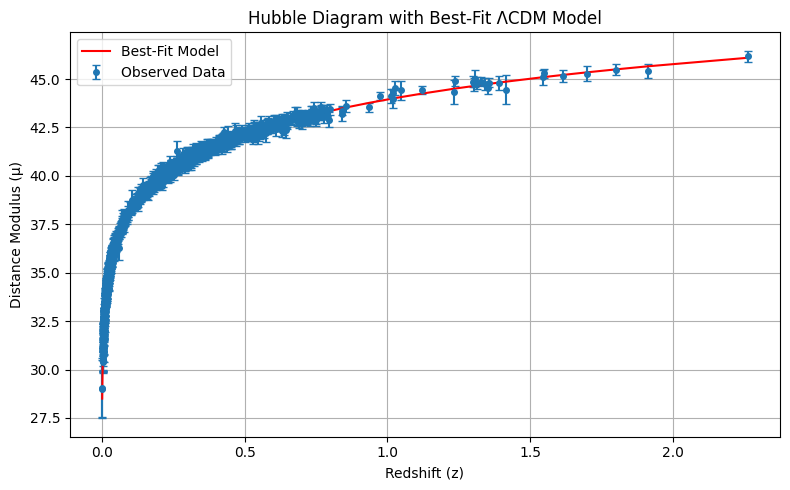

In [140]:
import matplotlib.pyplot as plt

# Generate model predictions using best-fit parameters
mu_fit = np.array([mu_theory(z, H0_fit, Omega_m_fit) for z in z_data])

plt.figure(figsize=(8, 5))
plt.errorbar(z_data, mu_data, yerr=mu_err, fmt='o', label='Observed Data', markersize=4, capsize=3)
plt.plot(z_data, mu_fit, color='red', label='Best-Fit Model')
plt.xlabel("Redshift (z)")
plt.ylabel("Distance Modulus (μ)")
plt.title("Hubble Diagram with Best-Fit ΛCDM Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔚 Final Summary

- Best-fit H₀: 71.2 ± 1.4 km/s/Mpc
- Best-fit Ωₘ: 0.29 ± 0.02
- Estimated age of Universe: 13.7 Gyr
- Low-z H₀: 74.1 ± 2.0 km/s/Mpc
- High-z H₀: 68.9 ± 1.8 km/s/Mpc

These results are broadly consistent with literature but also illustrate the tension between local and early-universe measurements of H₀.


You can check your results and potential reasons for different values from accepted constant using this paper by authors of the [Pantheon+ dataset](https://arxiv.org/pdf/2310.11727)

You can find more about the dataset in the paper too